In this notebook, I analyze the 1st TransformerBlock, as that's were the first errors occur

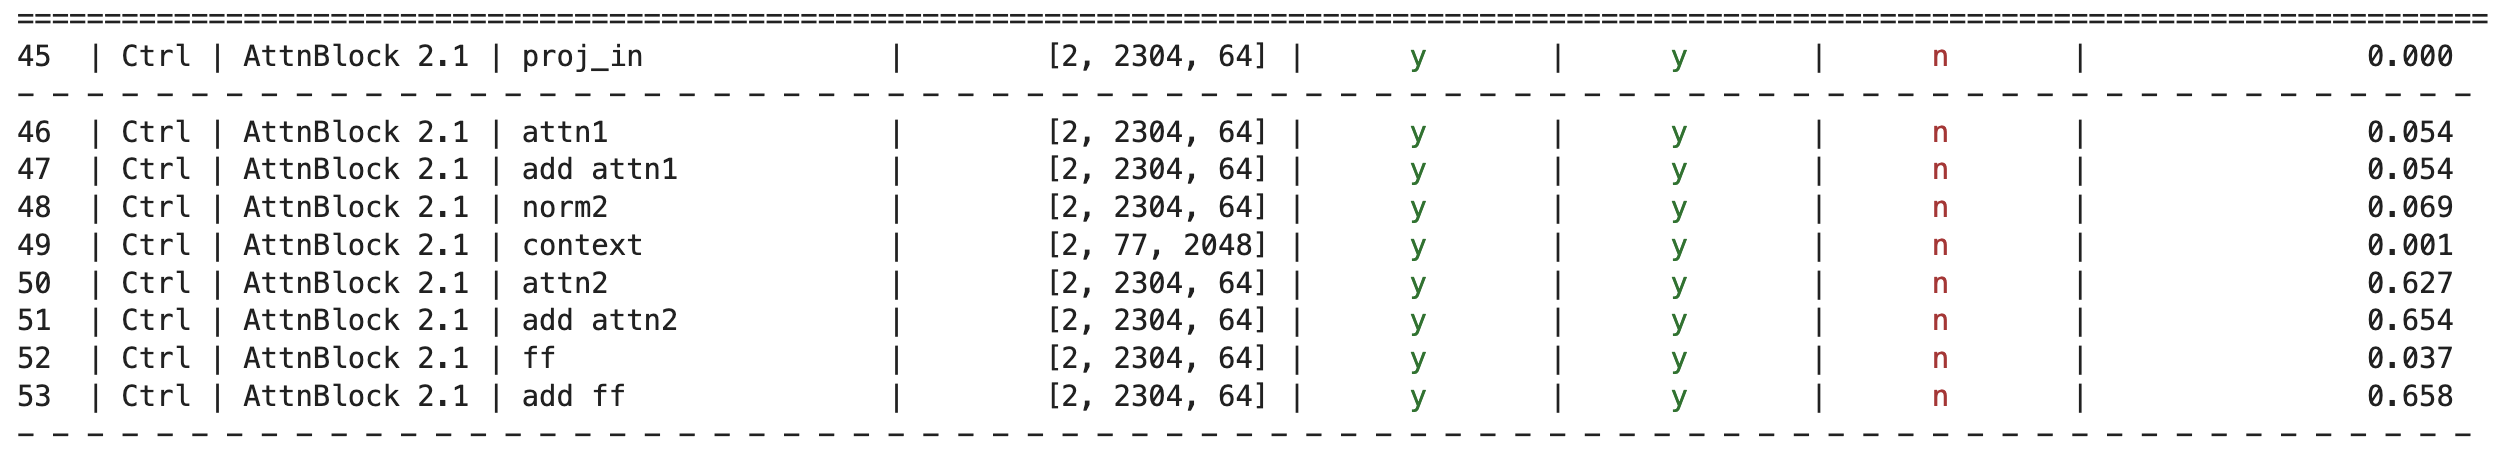

___

In [1]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # needed to make torch deterministic

In [2]:
import scripts.control_utils as cu
import torch
torch.set_printoptions(linewidth=200)

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


In [3]:
torch.use_deterministic_algorithms(True)

In [4]:
path_to_config = 'cnxs_config/sdxl/sdxl_encD_canny_48m.yaml'

If this results in the kernel crashing, I'm using too much GPU memory elsewhere. Shut down every other kernel and try again.

In [5]:
model = cu.create_model(path_to_config).to('cuda')

Building a Downsample layer with 2 dims.
  --> settings are: 
 in-chn: 320, out-chn: 320, kernel-size: 3, stride: 2, padding: 1
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
Building a Downsample layer with 2 dims.
  --> settings are: 
 in-chn: 640, out-chn: 640, kernel-size: 3, stride: 2, padding: 1
constructing SpatialTransformer of depth 10 w/ 1280 channels and 20 heads
constructing SpatialTransformer of depth 10 w/ 1280 channels and 20 heads
constructing SpatialTransformer of depth 10 w/ 1280 channels and 20 heads
constructing SpatialTransformer of depth 10 w/ 1280 channels and 20 heads
constructing SpatialTransformer of depth 10 w/ 1280 channels and 20 heads
constructing SpatialTransformer of depth 10 w/ 1280 channels and 20 heads
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
constructing

Load output before 1st control attention

In [6]:
from types import SimpleNamespace

def tensor_file(i): return f'logs/cloud/tensor_{i}.pt'

inp = SimpleNamespace(
    context = SimpleNamespace(t=torch.load(tensor_file(26), map_location='cuda'), expected_err=0.000),
    proj_in = SimpleNamespace(t=torch.load(tensor_file(44), map_location='cuda'), expected_err=0.000),
    attn1   = SimpleNamespace(t=torch.load(tensor_file(45), map_location='cuda'), expected_err=0.054),
    attn2   = SimpleNamespace(t=torch.load(tensor_file(49), map_location='cuda'), expected_err=0.627),
    feedf   = SimpleNamespace(t=torch.load(tensor_file(51), map_location='cuda'), expected_err=0.037),
)

Reminder: This is what a transformer block does:

In [7]:
# h += attn1(norm1(h)) # 1. Self-Attention
# h += attn2(norm2(h)) # 2. Cross-Attention
# h += ff(norm3(h))    # 3. Feed-forward
# return h

In [8]:
attn_block = model.model.control_model.input_blocks[4][1]
attn_block

SpatialTransformer(
  (norm): GroupNorm_leq32(32, 64, eps=1e-05, affine=True)
  (proj_in): Linear(in_features=64, out_features=64, bias=True)
  (transformer_blocks): ModuleList(
    (0-1): 2 x BasicTransformerBlock(
      (attn1): MemoryEfficientCrossAttention(
        (to_q): Linear(in_features=64, out_features=64, bias=False)
        (to_k): Linear(in_features=64, out_features=64, bias=False)
        (to_v): Linear(in_features=64, out_features=64, bias=False)
        (to_out): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (ff): FeedForward(
        (net): Sequential(
          (0): GEGLU(
            (proj): Linear(in_features=64, out_features=512, bias=True)
          )
          (1): Dropout(p=0.0, inplace=False)
          (2): Linear(in_features=256, out_features=64, bias=True)
        )
      )
      (attn2): MemoryEfficientCrossAttention(
        (to_q): Linear(in_features=64, ou

In [9]:
norm1 = attn_block.transformer_blocks[0].norm1
attn1 = attn_block.transformer_blocks[0].attn1
norm2 = attn_block.transformer_blocks[0].norm2
attn2 = attn_block.transformer_blocks[0].attn2
norm3 = attn_block.transformer_blocks[0].norm3
feedf = attn_block.transformer_blocks[0].ff

In [10]:
h = inp.proj_in.t

x_norm1 = norm1(h)
x_attn1 = attn1(x_norm1)
h += x_attn1

x_norm2 = norm2(h)
x_attn2 = attn2(x_norm2, inp.context.t)
h += x_attn2

x_norm3 = norm3(h)
x_feedf = feedf(x_norm3)

In [11]:
def mae(t1,t2):
    if t1.shape!=t1.shape: raise ValueError("Shapes don't match")
    return (t1-t2).abs().mean().detach()

In [12]:
torch.allclose(x_attn1, inp.attn1.t), torch.allclose(x_attn2, inp.attn2.t), torch.allclose(x_feedf, inp.feedf.t)

(True, True, True)

I can exactly reproduce the intermediate attention outputs, so I understood it :)

Let's compute attention wrong, by ingnoring to add back the attn1/attn2 output

In [13]:
bad_x_norm1 = norm1(inp.proj_in.t)
bad_x_attn1 = attn1(bad_x_norm1)

bad_x_norm2 = norm2(bad_x_attn1)
bad_x_attn2 = attn2(bad_x_norm2, inp.context.t)

bad_x_norm3 = norm3(bad_x_attn2)
bad_x_feedf = feedf(bad_x_norm3)

In [14]:
mae(bad_x_attn1, inp.attn1.t), mae(bad_x_attn2, inp.attn2.t), mae(bad_x_feedf, inp.feedf.t)

(tensor(0.2496, device='cuda:0'),
 tensor(0.8356, device='cuda:0'),
 tensor(0.0615, device='cuda:0'))

In [15]:
torch.set_printoptions(precision=3)
def print_head(m): print(m.weight.data.flatten()[:10])

In [16]:
print_head(attn1.to_q)
print_head(attn1.to_k)
print_head(attn1.to_v)
print_head(attn1.to_out[0])

print_head(attn2.to_q)
print_head(attn2.to_k)
print_head(attn2.to_v)
print_head(attn2.to_out[0])

print_head(feedf.net[2])

tensor([-0.071, -0.062, -0.003, -0.056,  0.030, -0.003, -0.015, -0.142, -0.017, -0.075], device='cuda:0')
tensor([ 0.073,  0.008,  0.053, -0.025,  0.056,  0.094,  0.037, -0.085,  0.065, -0.010], device='cuda:0')
tensor([-0.092,  0.013,  0.104, -0.014, -0.075, -0.126, -0.028, -0.007,  0.080,  0.094], device='cuda:0')
tensor([-0.071, -0.053, -0.049, -0.112, -0.016, -0.115, -0.001,  0.109,  0.055,  0.020], device='cuda:0')
tensor([ 0.091,  0.001, -0.058,  0.122, -0.091, -0.073,  0.009,  0.032,  0.011,  0.037], device='cuda:0')
tensor([ 0.003, -0.020,  0.015,  0.005, -0.025, -0.025, -0.016,  0.003,  0.009,  0.024], device='cuda:0')
tensor([ 0.021, -0.021, -0.020, -0.028, -0.007,  0.028,  0.028, -0.014,  0.003,  0.029], device='cuda:0')
tensor([-0.042, -0.100, -0.041,  0.014,  0.087,  0.011, -0.054,  0.069,  0.096, -0.027], device='cuda:0')
tensor([-0.015,  0.029, -0.066, -0.034, -0.022, -0.020, -0.085, -0.030, -0.075, -0.012], device='cuda:0')


These looks identical to the diffusers weights.

But let's check exactly.

In [17]:
attn2.to_q.bias

In [27]:
from types import SimpleNamespace

tf_modules = [
    attn1.to_q, attn1.to_k, attn1.to_v, attn1.to_out[0],
    attn2.to_q, attn2.to_k, attn2.to_v, attn2.to_out[0],
    feedf.net[2]
]

tf_modules_names = [
    'attn1.to_q', 'attn1.to_k', 'attn1.to_v', 'attn1.to_out',
    'attn2.to_q', 'attn2.to_k', 'attn2.to_v', 'attn2.to_out',
    'feedf.net'
]


def param_obj(name,wb,tensor): return SimpleNamespace(name=name, wb=wb, t=tensor.data.cpu().detach())

params = []
for m,n in zip(tf_modules, tf_modules_names):
    params.append(param_obj(n,'weight',m.weight))
    if hasattr(m,'bias') and m.bias is not None: params.append(param_obj(n,'bias',m.weight))

In [28]:
for p in params: print(p.name,p.wb, end=' | ')

attn1.to_q weight | attn1.to_k weight | attn1.to_v weight | attn1.to_out weight | attn1.to_out bias | attn2.to_q weight | attn2.to_k weight | attn2.to_v weight | attn2.to_out weight | attn2.to_out bias | feedf.net weight | feedf.net bias | 

In [29]:
import pickle
with open('first_transformer_params.pkl', 'wb') as f: pickle.dump(params, f)

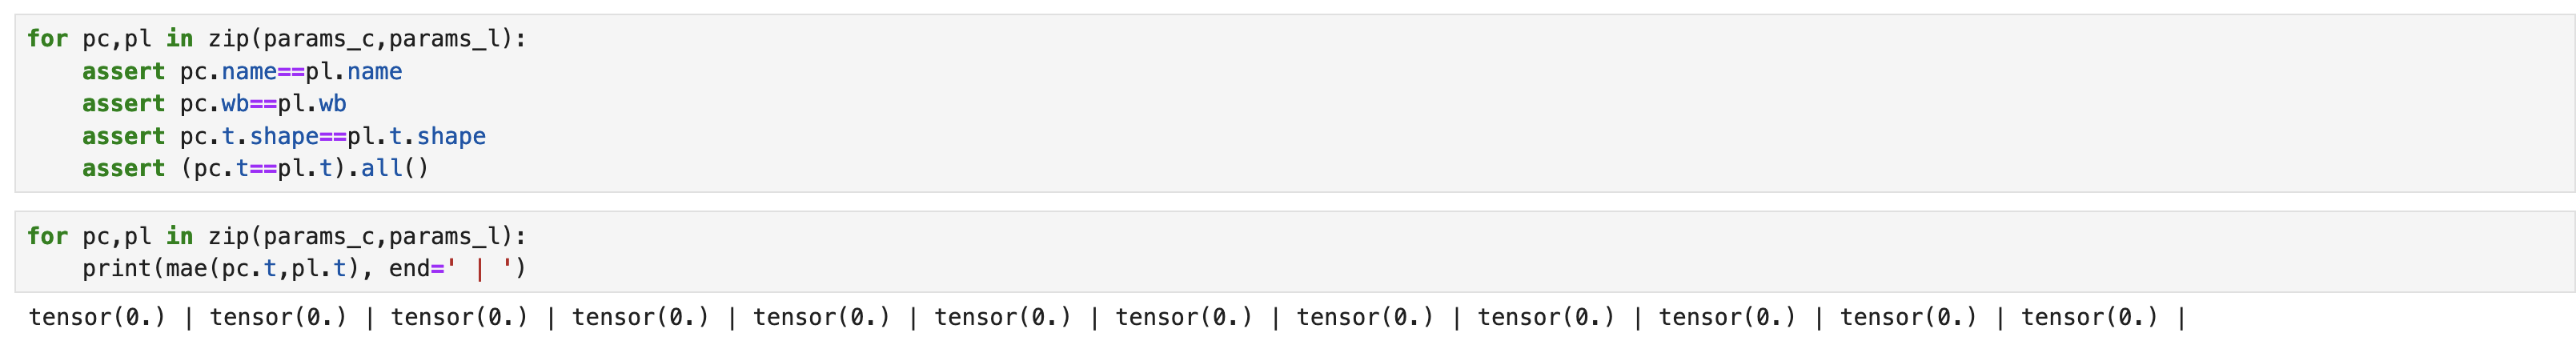
Yes, all params are exactly equal.

**So, we know:**
- cloud modules(cloud inp) = cloud outp
- local modules(cloud inp) = ~loca outp

Therefore, cloud modules and local modules must be somehow different.
But their weights look identical.

In [35]:
from util import public_attrs

In [36]:
public_attrs(attn1, 'hea')

['dim_head', 'heads']

In [37]:
attn1.dim_head, attn1.heads

(64, 1)

In [38]:
base_attn_block = model.model.diffusion_model.input_blocks[4][1]
base_attn1 = base_attn_block.transformer_blocks[0].attn1
base_attn1.dim_head, base_attn1.heads

(64, 10)

It seems I have created the control unet a bit wrong. I need to ensure there are 64 channels per head (which results in there only being 1 head). 